### Parameters, imports etc.

In [1]:
import io
import numpy as np
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from keras_tqdm import TQDMNotebookCallback
from skimage import color
from clr_callback import *
from hdfstore import *
from Utils import *
from tqdm import tqdm
import keras as k
import matplotlib.pyplot as plt
import h5py
import cv2 as cv
from keras.models import load_model

'''
Conf specifies model architechture where 1 row of conf specifies one layer: = 
[No. filters, stride, dialation, BatchNorm_bool, upsampling_bool]
'''

conf =  [[64,  1, (1,1), False, False],
         [64,  2, (1,1), True,  False],
         [128, 1, (1,1), False, False],
         [128, 2, (1,1), True,  False],
         [256, 1, (1,1), False, False],
         [256, 1, (1,1), False, False],
         [256, 2, (1,1), True,  False],
         [512, 1, (1,1), False, False],
         [512, 1, (1,1), False, False],
         [512, 1, (1,1), True,  False],
#          [512, 1, (2,2), False, False],
#          [512, 1, (2,2), False, False],
#          [512, 1, (2,2), True,  False],
#          [512, 1, (2,2), False, False],
#          [512, 1, (2,2), False, False],
#          [512, 1, (2,2), True,  False],
         [256, 1, (1,1), False, False],
         [256, 1, (1,1), False, False],
         [256, 1, (1,1), True,  False], 
         [128, 1, (1,1), False, True ],
         [128, 1, (1,1), False, False],
         [128, 1, (1,1), False, False]]



Using TensorFlow backend.


### Build model

In [2]:
class LossHistory(k.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))


training_generator = DataGenerator('train', 100)
validation_generator = DataGenerator('val', 10)

history = LossHistory()
model = net_builder(conf)
opti = optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss = 'categorical_crossentropy', optimizer = opti, metrics = ['accuracy'])
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
clr = CyclicLR(base_lr=0.00001, max_lr=0.0001, step_size=800.)



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Fit model

In [13]:
history = model.fit_generator(generator=training_generator, epochs = 500, validation_data=validation_generator, 
                    callbacks=[mc, clr, TQDMNotebookCallback()], verbose = 0)

### Load best model from callbacks

In [5]:
saved_model = load_model('best_model.h5')

### Plot loss curves

In [ ]:
print(history.history.keys())

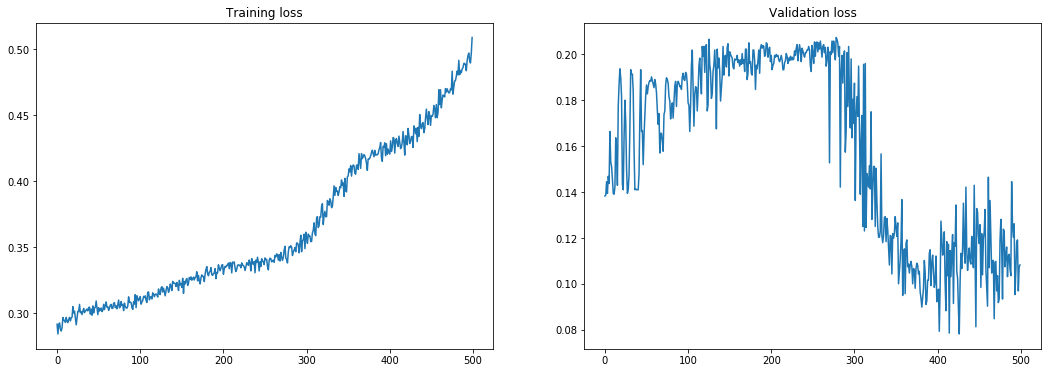

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(18, 6))
ax1.set_title('Training loss')
ax2.set_title('Validation loss')
ax1.plot(history.history['acc'])
ax2.plot(history.history['val_acc'])
plt.savefig('first_train_using_cyclic.pdf')
plt.show()

### Training image comparrisons

In [8]:
imgs = load_data('Data/train_data_batch_1')

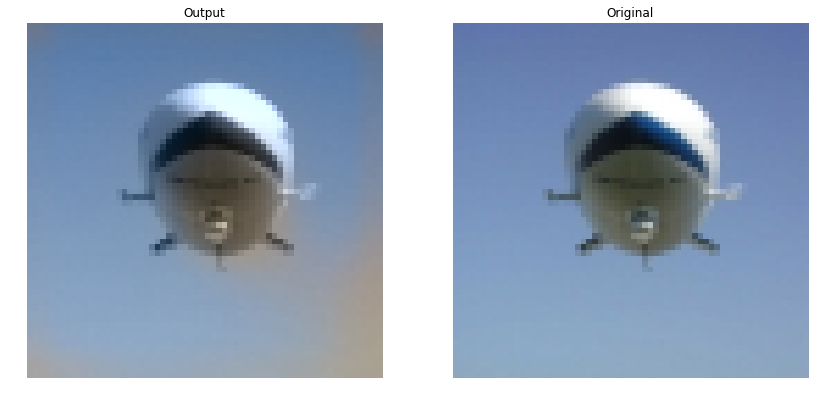

In [21]:
c = 7

sample = np.reshape(gen_input(imgs[c]), (1,64,64,1))

orig = np.resize(sample, (64,64,1))
img = model.predict(sample)
img = decode_prediction(img)
img = cv.resize(img, (64, 64), cv.INTER_CUBIC)
img_lab_out = np.concatenate((orig+50,img),axis=2)
img_rgb_out = (255*np.clip(color.lab2rgb(img_lab_out),0,1)).astype('uint8')

#Creates two subplots and unpacks the output array immediately
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 14))
ax1.set_title('Output')
ax1.imshow(img_rgb_out)
ax2.set_title('Original')
ax1.axis('off')
ax2.axis('off')
ax2.imshow(imgs[c])
plt.show()

### Validation image comparrisons

In [ ]:
val = load_data('Data/val_data')

In [ ]:
c = 63

sample = np.reshape(val_inps[c], (1,64,64,1))
orig = np.resize(sample, (64,64,1))
img = saved_model.predict(sample)
img = decode_prediction(img)
img = cv.resize(img, (64, 64), cv.INTER_CUBIC)
img_lab_out = np.concatenate((orig+50,img),axis=2)
img_rgb_out = (255*np.clip(color.lab2rgb(img_lab_out),0,1)).astype('uint8')

#Creates two subplots and unpacks the output array immediately
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(14, 14))
ax1.set_title('Output')
ax1.imshow(img_rgb_out)
ax2.set_title('Original')
ax1.axis('off')
ax2.axis('off')
ax2.imshow(val[c])
plt.show()